<a href="https://colab.research.google.com/github/k-sidana-77/Topsis-for-pre-trained-models/blob/main/Text_conversational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluating gpt2...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating facebook/opt-125m...
Evaluating microsoft/DialoGPT-small...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating EleutherAI/gpt-neo-125M...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Evaluating bigscience/bloom-560m...
Evaluating google/flan-t5-small...
                      Model  ROUGE-1 F1  ROUGE-2 F1  ROUGE-L F1  \
2  microsoft/DialoGPT-small    0.204117    0.126050    0.204117   
5      google/flan-t5-small    0.212970    0.087719    0.212970   
0                      gpt2    0.230256    0.100452    0.208750   
3   EleutherAI/gpt-neo-125M    0.173515    0.081617    0.173515   
1         facebook/opt-125m    0.169305    0.069233    0.157942   
4     bigscience/bloom-560m    0.199753    0.089935    0.174900   

   Inference Time  Model Size  TOPSIS Score  
2        0.193865       500.0      0.912653  
5        0.559597       500.0      0.795280  
0        3.036630       500.0      0.730781  
3        3.097955       500.0      0.618199  
1        2.831310       500.0      0.592801  
4       11.391386       500.0      0.151235  


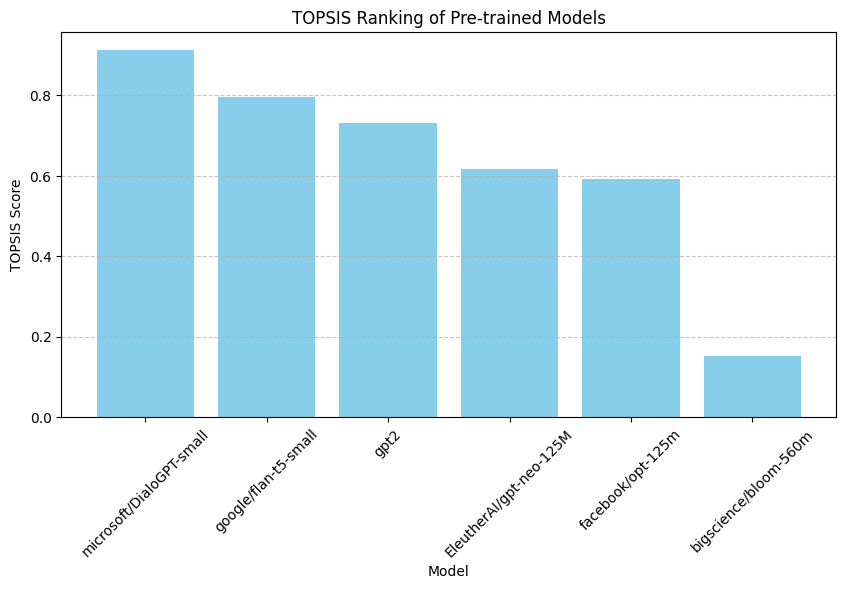

In [4]:
!pip install rouge-score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import torch
from transformers import AutoModelForSeq2SeqLM, AutoModelForCausalLM, AutoTokenizer
from rouge_score import rouge_scorer
import os

# Reference: This implementation applies the TOPSIS method to rank six pre-trained conversational AI models
# based on multiple evaluation criteria: ROUGE-1 F1, ROUGE-2 F1, ROUGE-L F1 (higher is better),
# Inference Time and Model Size (lower is better).

prompts = [
    "Tell me about the latest advancements in AI.",
    "What should I do if I get lost in a forest?"
]

ideal_answers = [
    "Recent advancements in AI include improvements in large language models like GPT-4, increased efficiency in reinforcement learning, and better multimodal understanding. Companies like OpenAI and DeepMind are focusing on safe and responsible AI development.",
    "If you get lost in a forest, stay calm and try to retrace your steps. Look for landmarks, conserve energy, and if you have a phone, try to call emergency services. Building a shelter and finding a water source are also critical."
]

# Define models (only open-source and compatible models)
model_names = [
    "gpt2",
    "facebook/opt-125m",
    "microsoft/DialoGPT-small",
    "EleutherAI/gpt-neo-125M",
    "bigscience/bloom-560m",
    "google/flan-t5-small"
]

# Model types
model_types = {
    "gpt2": AutoModelForCausalLM,
    "facebook/opt-125m": AutoModelForCausalLM,
    "microsoft/DialoGPT-small": AutoModelForCausalLM,
    "EleutherAI/gpt-neo-125M": AutoModelForCausalLM,
    "bigscience/bloom-560m": AutoModelForCausalLM,
    "google/flan-t5-small": AutoModelForSeq2SeqLM
}

def compute_rouge_scores(predicted, reference):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(predicted, reference)
    return scores["rouge1"].fmeasure, scores["rouge2"].fmeasure, scores["rougeL"].fmeasure

def evaluate_models(model_names, prompts, ideal_answers):
    decision_matrix = []

    for model_name in model_names:
        print(f"Evaluating {model_name}...")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model_class = model_types[model_name]
        model = model_class.from_pretrained(model_name)

        rouge1_f1, rouge2_f1, rougeL_f1 = 0, 0, 0
        inference_times = []

        for prompt, ideal in zip(prompts, ideal_answers):
            inputs = tokenizer(prompt, return_tensors="pt")
            start_time = time.time()
            outputs = model.generate(**inputs, max_new_tokens=50)
            end_time = time.time()

            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            r1, r2, rL = compute_rouge_scores(generated_text, ideal)
            rouge1_f1 += r1
            rouge2_f1 += r2
            rougeL_f1 += rL
            inference_times.append(end_time - start_time)

        avg_rouge1 = rouge1_f1 / len(prompts)
        avg_rouge2 = rouge2_f1 / len(prompts)
        avg_rougeL = rougeL_f1 / len(prompts)
        avg_inference_time = sum(inference_times) / len(inference_times)
        model_size = 500  # Reduced approximation due to smaller models

        decision_matrix.append([avg_rouge1, avg_rouge2, avg_rougeL, avg_inference_time, model_size])

    return np.array(decision_matrix)

# Generate decision matrix
decision_matrix = evaluate_models(model_names, prompts, ideal_answers)

# Define weights for criteria (must sum to 1)
weights = np.array([0.25, 0.2, 0.2, 0.15, 0.2])

# Define criteria: -1 for non-beneficial (lower better), 1 for beneficial (higher better)
criteria = np.array([1, 1, 1, -1, -1])

def topsis_ranking(decision_matrix, weights, criteria, model_names):
    norm_matrix = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))
    weighted_matrix = norm_matrix * weights
    ideal_solution = np.max(weighted_matrix, axis=0) * (criteria == 1) + np.min(weighted_matrix, axis=0) * (criteria == -1)
    negative_ideal_solution = np.min(weighted_matrix, axis=0) * (criteria == 1) + np.max(weighted_matrix, axis=0) * (criteria == -1)
    distance_ideal = np.sqrt(np.sum((weighted_matrix - ideal_solution) ** 2, axis=1))
    distance_negative_ideal = np.sqrt(np.sum((weighted_matrix - negative_ideal_solution) ** 2, axis=1))
    topsis_scores = distance_negative_ideal / (distance_ideal + distance_negative_ideal)
    ranked_models = sorted(zip(model_names, topsis_scores), key=lambda x: x[1], reverse=True)
    return ranked_models, topsis_scores

ranked_models, topsis_scores = topsis_ranking(decision_matrix, weights, criteria, model_names)

# Create and display a table with all evaluation parameters
df_results = pd.DataFrame(decision_matrix, columns=["ROUGE-1 F1", "ROUGE-2 F1", "ROUGE-L F1", "Inference Time", "Model Size"])
df_results.insert(0, "Model", model_names)
df_results["TOPSIS Score"] = topsis_scores
df_results = df_results.sort_values(by="TOPSIS Score", ascending=False)
print(df_results)
df_results.to_csv("model_evaluation_results.csv", index=False)

plt.figure(figsize=(10, 5))
plt.bar(df_results["Model"], df_results["TOPSIS Score"], color='skyblue')
plt.xlabel("Model")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Pre-trained Models")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
